# Import Statements
For required libraries.

In [2]:
# Import statements
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3

2023-06-07 16:33:16.303621: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 16:33:16.305692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:33:16.343052: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 16:33:16.344081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 16:33:17.096949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Check dataset proportions
By looking at the number of items.

In [3]:
# Dataset Directories for Fauna
TRAINING_DIR = "./datasets/fauna/train"
VALIDATION_DIR = "./datasets/fauna/val"

# Fauna Labels
FAUNA_LABELS = next(os.walk(TRAINING_DIR))[1]
FAUNA_LABELS.sort()
print(FAUNA_LABELS)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


Observing the first three animal images.

Animal: antelope
Training images: 48
Validation images: 12
Sample antelope image:


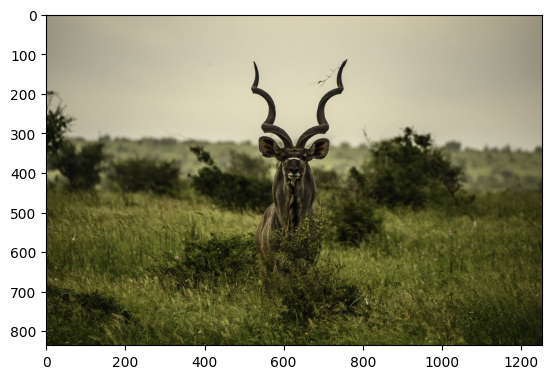


Animal: badger
Training images: 48
Validation images: 12
Sample badger image:


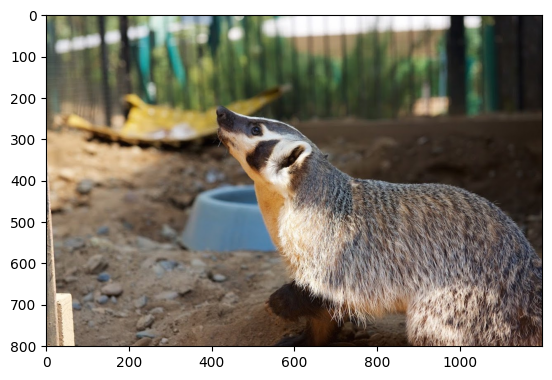


Animal: bat
Training images: 48
Validation images: 12
Sample bat image:


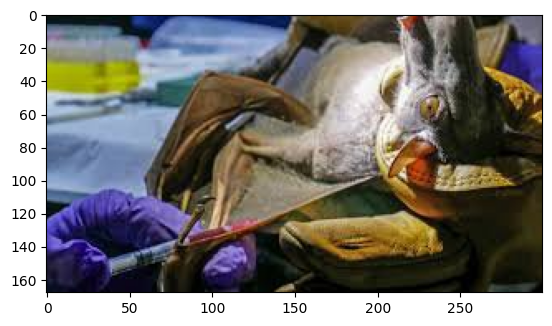

In [4]:
for animal in FAUNA_LABELS[0:3]:
    # preparing directories
    train_animal_dir = os.path.join(TRAINING_DIR, animal)
    val_animal_dir = os.path.join(VALIDATION_DIR, animal)
    # displaying the results
    print(f"Animal: {animal}")
    print(f"Training images: {len(os.listdir(train_animal_dir))}")
    print(f"Validation images: {len(os.listdir(val_animal_dir))}")
    print(f"Sample {animal} image:")
    plt.imshow(load_img(f"{os.path.join(train_animal_dir, os.listdir(train_animal_dir)[0])}"))
    plt.show()
    print()

# Preprocessing the dataset
By using TensorFlow's ImageDataGenerator.

Create dataset generators, and augment the training dataset.

In [5]:
def train_val_generators(train_dir, valid_dir, image_size):
    # Train dataset will be augmented as follows
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        # zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest')
    # Initialize training generator
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        batch_size=64, 
                                                        class_mode='categorical',
                                                        target_size=(image_size, image_size))
    
    # Validation dataset will not be augmented 
    validation_datagen = ImageDataGenerator(rescale=1./255)
    # Initialize validation generator
    validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                                    batch_size=64, 
                                                                    class_mode='categorical',
                                                                    target_size=(image_size, image_size))
    return train_generator, validation_generator

In [6]:
IMAGE_SIZE = 225
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE)

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


# Model
Create a model using transfer learning.

## InceptionV3
Model creation.

Download weights.

In [26]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-07 16:54:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  57.5MB/s    in 1.5s    

2023-06-07 16:54:48 (57.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Initialize InceptionV3

In [27]:
def create_inception_base_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                                    include_top = False, 
                                    weights = None) 
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    return pre_trained_model

In [28]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_base_model = create_inception_base_model(local_weights_file)

In [29]:
def output_of_last_layer(inception_base_model):
    last_desired_layer = inception_base_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

inception_last_layer = output_of_last_layer(inception_base_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [32]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  # x = layers.Dense(1024, activation='relu')(x)
  # x = layers.Dropout(0.2)(x) 
  x = layers.Dense(90, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [33]:
model = create_final_model(inception_base_model, inception_last_layer)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 18,928,634 total parameters in this model.
There are 9,953,370 trainable parameters in this model.


Callback class.

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

## Model Training and Evaluation

In [35]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/10
2023-06-07 16:55:35.329760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
68/68 [==============================] - ETA: 0s - loss: 3.3082 - accuracy: 0.27642023-06-07 17:01:05.073418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
68/68 [==============================] - 397s 6s/step - loss: 3.3082 - accuracy: 0.2764 - val_loss: 1.9486 - val_accuracy: 0.5481
Epoch 2/10
68/68 [==============================] - 397s 6s/step - loss: 1.7374 - accuracy: 0.6181 - val_loss: 1.2270 - val_a

## Model Plotting

Text(0.5, 1.0, 'Training and validation loss')

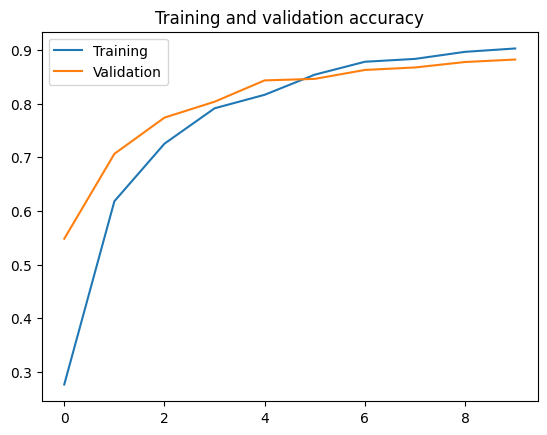

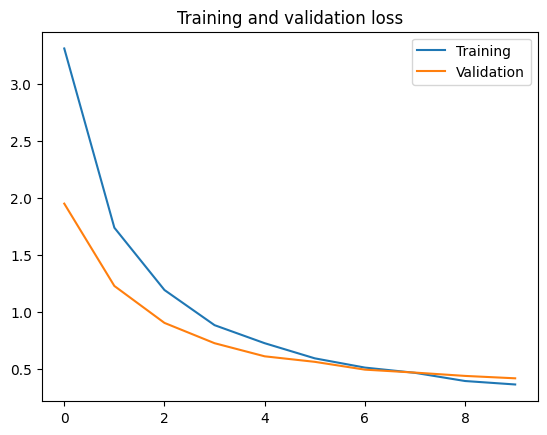

In [36]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

## Model Saving
As Keras HDF5 file.

In [37]:
import time
curr_time = int(time.time())
saved_model_path = f"./models/fauna/{curr_time}-inception_model.h5"

model.save(saved_model_path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c07056b3-cc2b-4586-9ad2-96584933fc91' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>